In [8]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
from pathlib import Path
from numpy.linalg import eigvals

temperature = 300  # K

Angle1 = np.deg2rad(np.array([ -3.94, 3.94, 16.5, 14.8, -14.8, -16.5]))
rotation1 = [0, 1, 0, 2, 0, 1]
Angle2 = np.deg2rad(np.array([-3.94, 3.94, 16.5, 14.8, -14.8, -16.5]))
rotation2 = [0, 1, 0, 3, 0, 1]
labels = {
    1: {'label': 'AIID-T', 'color': 'b'},
    2: {'label': 'T-T', 'color': 'm'},
    3: {'label': 'FT-FT', 'color': 'c'},
}

In [9]:
def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    if data[:, 0].max() - data[:, 0].min() != 360:
        mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
        combined = np.vstack((data, mirrored))
        combined = np.unique(combined, axis=0)
        return combined[np.argsort(combined[:, 0])]
    else:
        return data[np.argsort(data[:, 0])]


def fit_function(data_label):
    data = read_data(Path(f"{data_label['label']}.txt"))
    fitf = interp1d(data[:, 0],
                    data[:, 1],
                    kind='cubic',
                    fill_value="extrapolate")
    return fitf


def make_Mmat(all_data, Angle_rad, rotation_types, temperature):
    kTval = sc.R * temperature / 1000 # in kJ/mol
    M = len(rotation_types)
    A_list = []
    for i in range(M):
        rot_id = int(rotation_types[i])
        theta = float(Angle_rad[i])
        if rot_id == 0:
            m_i, s_i = 1.0, 0.0
        else:
            fitf = all_data[rot_id]
            Z, _ = quad(lambda phi_deg: np.exp(-fitf(phi_deg) / kTval),
                        0,
                        360,
                        limit=1000)
            m_i, _ = quad(lambda phi_deg: np.cos(np.deg2rad(phi_deg)) * np.exp(
                -fitf(phi_deg) / kTval),
                          0,
                          360,
                          limit=1000)
            m_i /= Z
            s_i, _ = quad(lambda phi_deg: np.sin(np.deg2rad(phi_deg)) * np.exp(
                -fitf(phi_deg) / kTval),
                          0,
                          360,
                          limit=1000)
            s_i /= Z

        S = np.array([[m_i, -s_i, 0.0], [s_i, m_i, 0.0], [0.0, 0.0, 1.0]])
        c = np.cos(theta)
        s = np.sin(theta)
        R_y = np.array([[c, 0.0, s], [0.0, 1.0, 0.0], [-s, 0.0, c]])
        A_list.append(S @ R_y)

    # Multiply all A_i for the repeat unit
    Mmat = np.eye(3)
    for A in A_list:
        Mmat = A @ Mmat
    return Mmat

def compute_persistence_terpolymer(Mmat1,
                                   Mmat2, prob):
    """
    Computes persistence length for a terpolymer made of two repeat units 
    appearing with probability prob and 1-prob.
    """
    Mmat_avg = prob * Mmat1 + (1 - prob) * Mmat2

    eigs = eigvals(Mmat_avg)
    lambda_max = float(np.max(np.abs(eigs)))

    if lambda_max >= 1.0:
        eps = 1e-12
        if lambda_max > 1.0 + 1e-8:
            print("Warning: lambda_max > 1 (numerical error)")
        lambda_max = min(lambda_max, 1.0 - eps)

    corr_length = -1.0 / np.log(lambda_max)
    return corr_length, lambda_max

In [10]:
all_data = {}
for key, label_info in labels.items():
    all_data[key] = fit_function(label_info)
matrix1 = make_Mmat(all_data, Angle1, rotation1, temperature)
matrix2 = make_Mmat(all_data, Angle2, rotation2, temperature)

In [11]:
lp_repeats, lam = compute_persistence_terpolymer(Mmat1=matrix1, Mmat2=matrix2, prob=0.4)

print(f"Max eigen value: lambda_max = {lam:.12f}")
print(f"Correlation length = {lp_repeats:.6f}")

Max eigen value: lambda_max = 0.942902519496
Correlation length = 17.009009


Correlation Length in Repeats for Terpolymer:
67.22873 (probability = 0.00)
37.58495 (probability = 0.10)
26.42952 (probability = 0.20)
20.59138 (probability = 0.30)
17.00901 (probability = 0.40)
14.59240 (probability = 0.50)
12.85615 (probability = 0.60)
11.55125 (probability = 0.70)
10.53685 (probability = 0.80)
9.72724 (probability = 0.90)
9.06731 (probability = 1.00)


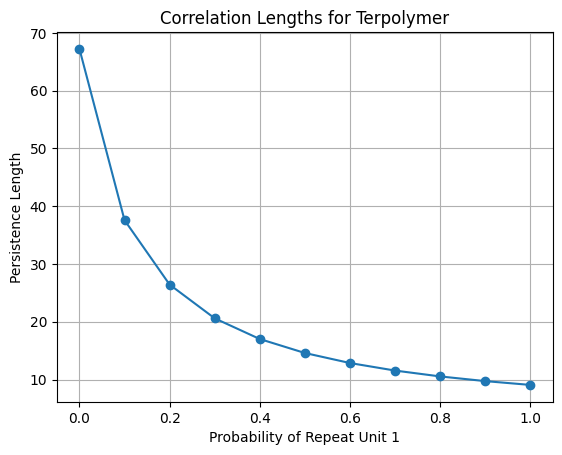

In [12]:
# scan 0-1
probs = np.linspace(0, 1, 11)
N_p = []
for prob in probs:
    lp_repeats, _ =  compute_persistence_terpolymer(Mmat1=matrix1, Mmat2=matrix2, prob=prob)
    N_p.append(lp_repeats)
plt.plot(probs, N_p, 'o-')
plt.title("Correlation Lengths for Terpolymer")
plt.xlabel("Probability of Repeat Unit 1")
plt.ylabel("Persistence Length")
plt.grid(True)

all_np = [f"{num:.5f} (probability = {prob:.2f})" for num, prob in zip(np.array(N_p), probs)]
print("Correlation Length in Repeats for Terpolymer:", )
print("\n".join(all_np))

Correlation Length in Repeats for Terpolymer:
14.59240 (Temperature = 300.00 K)
12.04828 (Temperature = 350.00 K)
10.33908 (Temperature = 400.00 K)
9.11253 (Temperature = 450.00 K)
8.19444 (Temperature = 500.00 K)
7.48688 (Temperature = 550.00 K)
6.92942 (Temperature = 600.00 K)
6.48226 (Temperature = 650.00 K)
6.11802 (Temperature = 700.00 K)


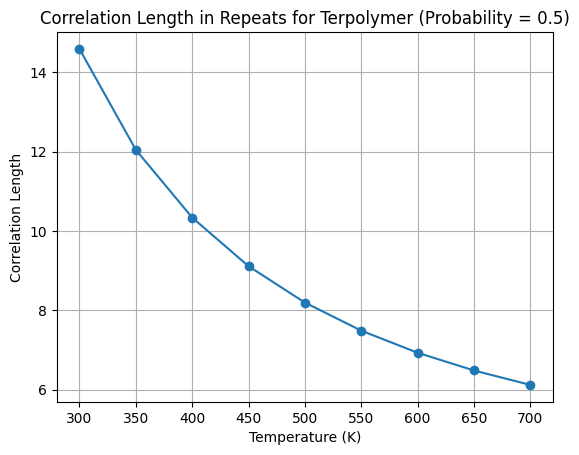

In [13]:
# scan temperaturem, prob = 0.5
temperatures = np.linspace(300, 700, 9)
Np_temperature = []
for temp in temperatures:
    m1 = make_Mmat(all_data, Angle1, rotation1, temp)
    m2 = make_Mmat(all_data, Angle2, rotation2, temp)
    lp_repeats, _ = compute_persistence_terpolymer(Mmat1=m1,
                                                   Mmat2=m2,
                                                   prob=0.5)
    Np_temperature.append(lp_repeats)
plt.plot(temperatures, Np_temperature, 'o-')
plt.title("Correlation Length in Repeats for Terpolymer (Probability = 0.5)")
plt.xlabel("Temperature (K)")
plt.ylabel("Correlation Length")
plt.grid(True)

all_np = [f"{num:.5f} (Temperature = {t:.2f} K)" for num, t in zip(Np_temperature, temperatures)]
print("Correlation Length in Repeats for Terpolymer:", )
print("\n".join(all_np))

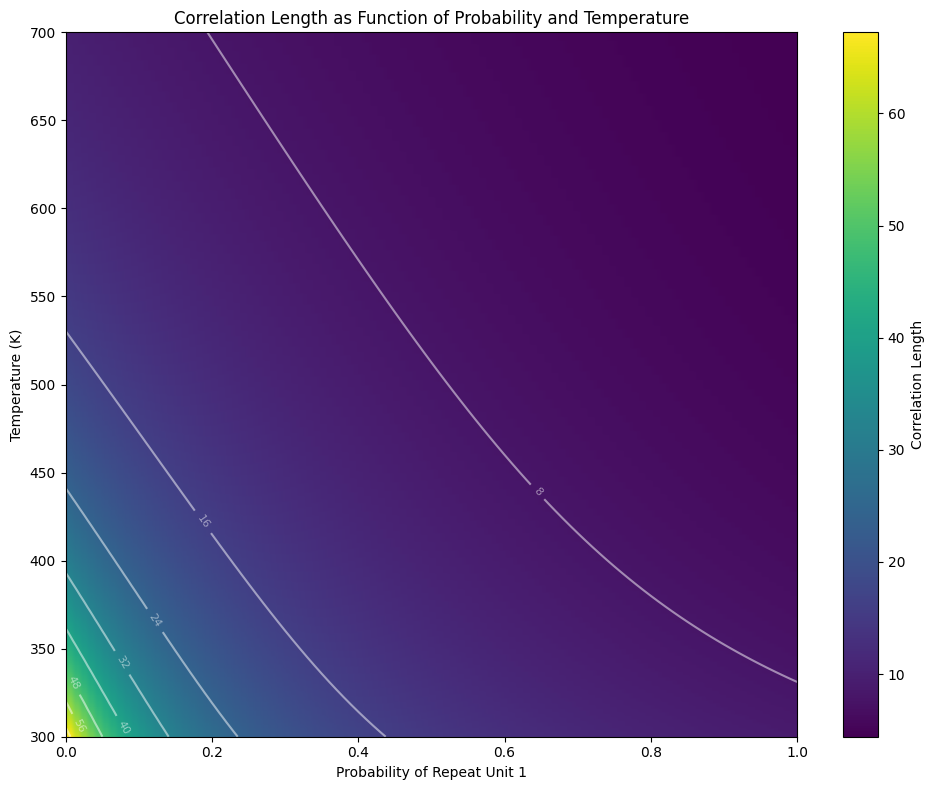

In [14]:
# scan both temperature and prob
temperatures_2d = np.linspace(300, 700, 401)
probs_2d = np.linspace(0, 1, 101)
lp_grid = np.zeros((len(temperatures_2d), len(probs_2d)))
for i, temp in enumerate(temperatures_2d):
    # Create matrices for this temperature
    m1 = make_Mmat(all_data, Angle1, rotation1, temp)
    m2 = make_Mmat(all_data, Angle2, rotation2, temp)

    for j, prob in enumerate(probs_2d):
        lp_repeats, _ = compute_persistence_terpolymer(Mmat1=m1,
                                                       Mmat2=m2,
                                                       prob=prob)
        lp_grid[i, j] = lp_repeats
plt.figure(figsize=(10, 8))
plt.imshow(lp_grid,
           extent=[
               probs_2d[0], probs_2d[-1], temperatures_2d[-1],
               temperatures_2d[0]
           ],
           aspect='auto',
           cmap='viridis')
plt.colorbar(label='Correlation Length')
plt.xlabel('Probability of Repeat Unit 1')
plt.ylabel('Temperature (K)')
plt.title('Correlation Length as Function of Probability and Temperature')
plt.gca().invert_yaxis() # To have lower temperatures at the bottom
contours = plt.contour(probs_2d, temperatures_2d, lp_grid, colors='white', alpha=0.5)
plt.clabel(contours, inline=True, fontsize=8)

plt.tight_layout()